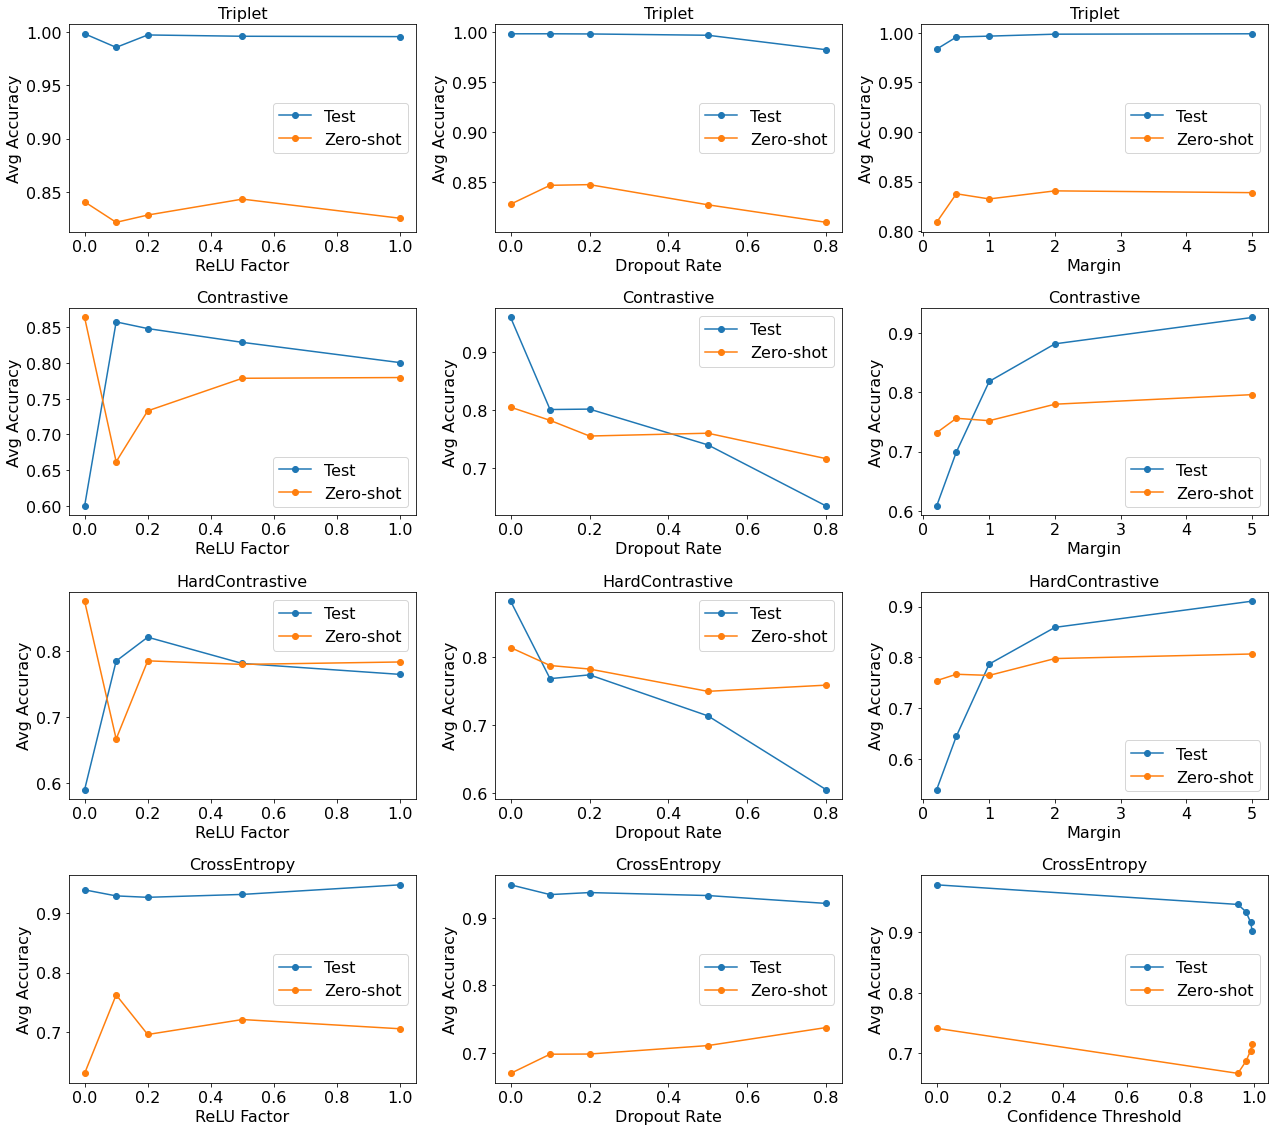

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Function to read and process each file
def process_file(filename):
    df = pd.read_csv(filename)
    
    if 'softmax' in filename:
        relu_avg = df.groupby('RELU')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        dropout_avg = df.groupby('DROPOUT')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        conf_threshold_avg = df.groupby('CONF_THRESHOLD')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        return relu_avg, dropout_avg, conf_threshold_avg, 'CONF_THRESHOLD'
    else:
        relu_avg = df.groupby('RELU')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        dropout_avg = df.groupby('DROPOUT')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        margin_avg = df.groupby('MARGIN')[['MAX_TEST_ACC', 'MAX_ZERO_ACC']].mean().reset_index()
        return relu_avg, dropout_avg, margin_avg, 'MARGIN'

# File pattern (modify the path according to your files' location)
file_pattern = 'global_stats_delta_20june2024/*.csv'
files = glob.glob(file_pattern)
order = ['triplet', 'contrastive', 'online', 'softmax']
files = sorted(files, key=lambda x: order.index(x.split('_')[-1].split('.')[0]))

# Initialize subplots
fig, axes = plt.subplots(len(files), 3, figsize=(18, 4 * len(files)))

# Process each file and plot
for i, file in enumerate(files):
    loss = file.split('_')[-1].split('.')[0]
    # capitalize the first letter
    loss = loss[0].upper() + loss[1:]
    loss = "HardContrastive" if loss == "Online" else loss
    loss = "CrossEntropy" if loss == "Softmax" else loss
    relu_avg, dropout_avg, param_avg, param_name = process_file(file)
    
    # Plot for RELU
    axes[i, 0].plot(relu_avg['RELU'], relu_avg['MAX_TEST_ACC'], label='Test', marker='o')
    axes[i, 0].plot(relu_avg['RELU'], relu_avg['MAX_ZERO_ACC'], label='Zero-shot', marker='o')
    axes[i, 0].set_title(f'{loss}')
    axes[i, 0].set_xlabel('ReLU Factor')
    axes[i, 0].set_ylabel('Avg Accuracy')
    axes[i, 0].legend()
    
    # Plot for DROPOUT
    axes[i, 1].plot(dropout_avg['DROPOUT'], dropout_avg['MAX_TEST_ACC'], label='Test', marker='o')
    axes[i, 1].plot(dropout_avg['DROPOUT'], dropout_avg['MAX_ZERO_ACC'], label='Zero-shot', marker='o')
    axes[i, 1].set_title(f'{loss}')
    axes[i, 1].set_xlabel('Dropout Rate')
    axes[i, 1].set_ylabel('Avg Accuracy')
    axes[i, 1].legend()
    
    # Plot for MARGIN or CONF_THRESHOLD
    axes[i, 2].plot(param_avg[param_name], param_avg['MAX_TEST_ACC'], label='Test', marker='o')
    axes[i, 2].plot(param_avg[param_name], param_avg['MAX_ZERO_ACC'], label='Zero-shot', marker='o')
    axes[i, 2].set_title(f'{loss}')
    axes[i, 2].set_xlabel("Margin" if param_name == "MARGIN" else "Confidence Threshold")
    axes[i, 2].set_ylabel('Avg Accuracy')
    axes[i, 2].legend()

font_size = 16
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)
plt.tight_layout()
plt.savefig('global_stats_delta.pdf')
plt.show()


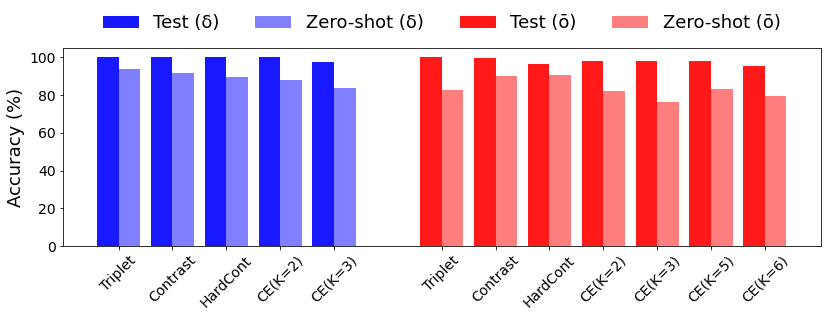

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('global_stats/best_of_all.csv')

# remove Loss from LOSS_NAME
df['LOSS_NAME'] = df['LOSS_NAME'].str.replace('Loss', '')
df['LOSS_NAME'] = df['LOSS_NAME'].str.replace('OnlineContrastive', 'HardCont')
df['LOSS_NAME'] = df['LOSS_NAME'].str.replace('CrossEntropy', 'CE')
df['LOSS_NAME'] = df['LOSS_NAME'].str.replace('Contrastive', 'Contrast')

# fill missing NUM_LABELS with 0
df['NUM_LABELS'] = df['NUM_LABELS'].fillna(0)
# Generate legend names
df['LEGEND_NAME'] = df['LOSS_NAME']
# append NUM_LABELS to legend name if it is not 0
df.loc[df['NUM_LABELS'] != 0, 'LEGEND_NAME'] = df['LEGEND_NAME'] + '(K=' + df['NUM_LABELS'].astype(int).astype(str) + ')'

# convert ACC% to float
df['MAX_TEST_ACC'] = df['MAX_TEST_ACC'].str.rstrip('%').astype('float')
df['MAX_ZERO_ACC'] = df['MAX_ZERO_ACC'].str.rstrip('%').astype('float')

# Separate the data into delta and other NEG_SET
delta_df = df[df['NEG_SET'] == 'delta']
other_df = df[df['NEG_SET'] != 'delta']

# Define the bar width
bar_width = 0.4

# Set the positions of the bars
r1 = np.arange(len(delta_df))
r2 = np.arange(len(other_df)) + len(delta_df) + 1

# Create the bar plot
plt.figure(figsize=(12, 5))

# Delta NEG_SET bars
colormapb = plt.get_cmap('tab20b')
colormapc = plt.get_cmap('Pastel1')

plt.bar(r1 - bar_width/2, delta_df['MAX_TEST_ACC'], color="blue", alpha=0.9, width=bar_width, label='Test (\u03B4)')
plt.bar(r1 + bar_width/2, delta_df['MAX_ZERO_ACC'], color="blue", alpha=0.5, width=bar_width, label='Zero-shot (\u03B4)')

# Other NEG_SET bars
plt.bar(r2 - bar_width/2, other_df['MAX_TEST_ACC'], color="red", alpha=0.9, width=bar_width, label='Test (\u014D)')
plt.bar(r2 + bar_width/2, other_df['MAX_ZERO_ACC'], color="red", alpha=0.5, width=bar_width, label='Zero-shot (\u014D)')

# Adding the legends for NEG_SET and ACC type
legend_labels = [f'{row["LEGEND_NAME"]}' for _, row in delta_df.iterrows()] + [f'{row["LEGEND_NAME"]}' for _, row in other_df.iterrows()]
plt.xticks(np.concatenate((r1, r2)), legend_labels, rotation=45)

# Add labels
#plt.xlabel('Configurations')
plt.ylabel('Accuracy (%)')
#plt.title('Test Accuracy and Zero-shot Accuracy for Different Configurations', pad=40)

# Move legend between title and plot, with 4 columns
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

font_size = 18
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size-4)
plt.rc('ytick', labelsize=font_size-4)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)
plt.tight_layout()
plt.savefig('figures/global_performance.pdf')
plt.show()
